In [15]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
import test_cuda
from helper_functions import plot_predictions, plot_decision_boundary
device = test_cuda.device

|          **Hyperparameter**         |                                           **Binary Classification**                                          |             **Multiclass classification**             |
|:-----------------------------------:|:------------------------------------------------------------------------------------------------------------:|:-----------------------------------------------------:|
|  Input layer shape (in_features)  | Same as number of features (e.g. 5 for age, sex, height, weight, smoking status in heart disease prediction) |             Same as binary classification             |
|           Hidden layer(s)           |                              Problem specific, minimum = 1, maximum = unlimited                              |             Same as binary classification             |
|       Neurons per hidden layer      |                                     Problem specific, generally 10 to 512                                    |             Same as binary classification             |
| Output layer shape (out_features) |                                          1 (one class or the other)                                          |   1 per class (e.g. 3 for food, person or dog photo)  |
|       Hidden layer activation       |                          Usually ReLU (rectified linear unit) but can be many others                         |             Same as binary classification             |
|          Output activation          |                                      Sigmoid ( torch.sigmoid in PyTorch)                                     |          Softmax ( torch.softmax in PyTorch)          |
|            Loss function            |                              Binary crossentropy ( torch.nn.BCELoss in PyTorch)                              | Cross entropy ( torch.nn.CrossEntropyLoss in PyTorch) |
|              Optimizer              |                  SGD (stochastic gradient descent), Adam (see torch.optim for more options)                  |             Same as binary classification             |

In [16]:
import sklearn
from sklearn.datasets import make_circles
import pandas as pd

In [17]:
n_samples = 10000

X, y = make_circles(n_samples, noise=0.03, random_state=42)

In [18]:
circles = pd.DataFrame({"X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
circles.head(10)

,X1,X2,label
0,0.046469,0.824778,1
1,1.005063,-0.433352,0
2,-0.583484,0.794528,0
3,0.984783,-0.325179,0
4,0.829930,-0.547223,0
5,-0.133929,0.776249,1
6,0.779197,0.645811,0
7,0.722955,0.173831,1
8,-0.121807,0.796951,1
9,0.849529,0.505678,0


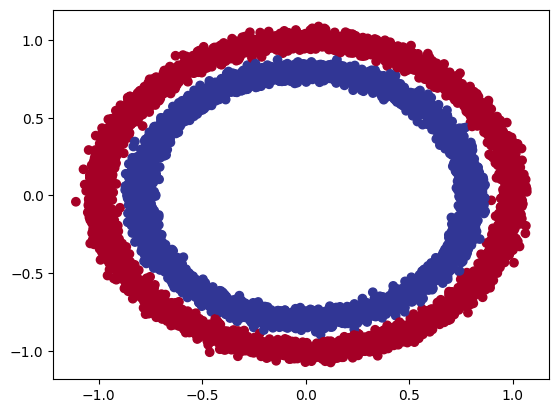

In [19]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0], 
            y=X[:, 1], 
            c=y, 
            cmap=plt.cm.RdYlBu);

In [20]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=25) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(8000, 2000, 8000, 2000)

In [22]:
# 1. Construct a model class that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling X and y input and output shapes
        self.layer_1 = nn.Linear(in_features=2, out_features=8) # takes in 2 features (X), produces 5 features
        self.layer_2 = nn.Linear(in_features=8, out_features=1) # takes in 5 features, produces 1 feature (y)
    
    # 3. Define a forward method containing the forward pass computation
    def forward(self, x):
        # Return the output of layer_2, a single feature, the same shape as y
        return self.layer_2(self.layer_1(x)) # computation goes through layer_1 first then the output of layer_1 goes through layer_2

# 4. Create an instance of the model and send it to target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=8, bias=True)
  (layer_2): Linear(in_features=8, out_features=1, bias=True)
)

In [23]:
# Replicate CircleModelV0 with nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [24]:
model_0.eval()

with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))

In [25]:
# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), 
                            lr=0.1)

In [26]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [27]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = model_0(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device 
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls
  
    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
    #                y_train) 
    loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                   y_train) 
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred) 

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.70707, Accuracy: 43.31% | Test loss: 0.70891, Test acc: 41.45%
Epoch: 10 | Loss: 0.69969, Accuracy: 46.65% | Test loss: 0.70225, Test acc: 45.30%
Epoch: 20 | Loss: 0.69659, Accuracy: 48.11% | Test loss: 0.69932, Test acc: 46.85%
Epoch: 30 | Loss: 0.69518, Accuracy: 49.10% | Test loss: 0.69787, Test acc: 47.00%
Epoch: 40 | Loss: 0.69447, Accuracy: 49.69% | Test loss: 0.69702, Test acc: 47.20%
Epoch: 50 | Loss: 0.69407, Accuracy: 50.04% | Test loss: 0.69645, Test acc: 47.35%
Epoch: 60 | Loss: 0.69382, Accuracy: 50.26% | Test loss: 0.69603, Test acc: 47.55%
Epoch: 70 | Loss: 0.69364, Accuracy: 50.36% | Test loss: 0.69569, Test acc: 47.85%
Epoch: 80 | Loss: 0.69352, Accuracy: 50.48% | Test loss: 0.69541, Test acc: 47.90%
Epoch: 90 | Loss: 0.69342, Accuracy: 50.39% | Test loss: 0.69517, Test acc: 47.95%


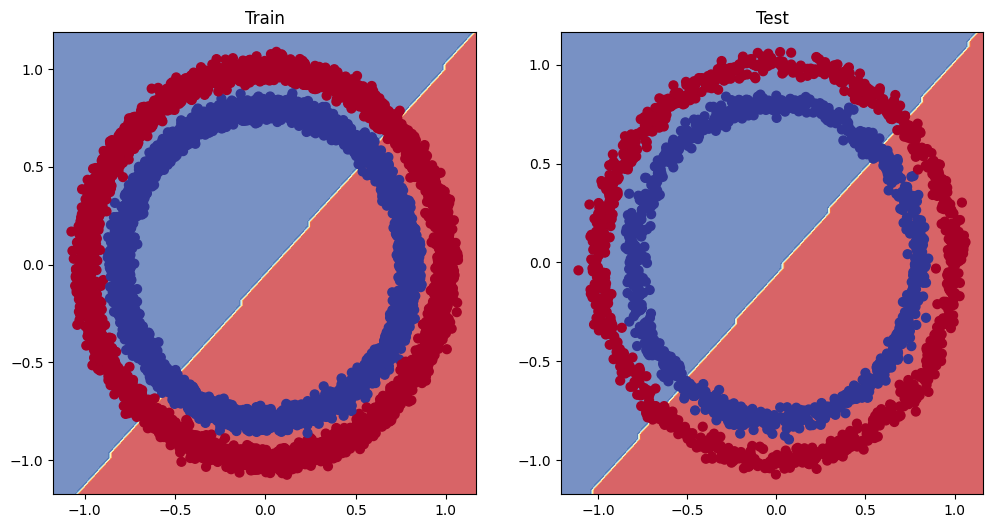

In [28]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

In [29]:
# Build model with non-linear activation function
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model 
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [30]:
# Setup loss and optimizer 
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

In [31]:
# Fit the model
torch.manual_seed(42)
epochs = 1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels
    
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_3(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calcuate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69298, Accuracy: 50.14% | Test Loss: 0.69290, Test Accuracy: 49.45%
Epoch: 100 | Loss: 0.69105, Accuracy: 56.74% | Test Loss: 0.69094, Test Accuracy: 57.30%
Epoch: 200 | Loss: 0.68948, Accuracy: 54.64% | Test Loss: 0.68934, Test Accuracy: 55.10%
Epoch: 300 | Loss: 0.68730, Accuracy: 54.69% | Test Loss: 0.68722, Test Accuracy: 54.85%
Epoch: 400 | Loss: 0.68390, Accuracy: 54.45% | Test Loss: 0.68393, Test Accuracy: 54.15%
Epoch: 500 | Loss: 0.67904, Accuracy: 54.40% | Test Loss: 0.67928, Test Accuracy: 54.05%
Epoch: 600 | Loss: 0.67175, Accuracy: 55.39% | Test Loss: 0.67218, Test Accuracy: 55.60%
Epoch: 700 | Loss: 0.66117, Accuracy: 59.21% | Test Loss: 0.66166, Test Accuracy: 59.15%
Epoch: 800 | Loss: 0.64498, Accuracy: 67.60% | Test Loss: 0.64525, Test Accuracy: 68.00%
Epoch: 900 | Loss: 0.61439, Accuracy: 74.05% | Test Loss: 0.61449, Test Accuracy: 74.10%


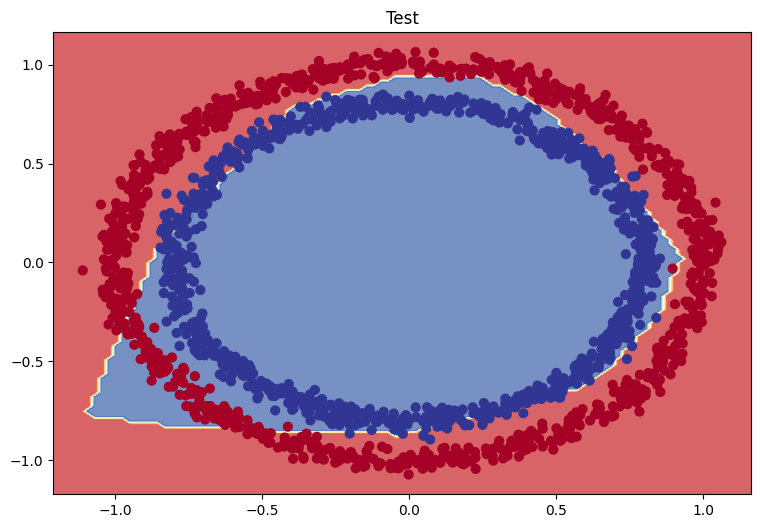

In [32]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(9, 6))
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity